In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"


In [2]:

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [3]:
#파일이름 sort해서 list저장
data_path='/disk1/data_liverbound_noclip/'
name_list=os.listdir(data_path)

segmentation_data = [files[:-4] for files in name_list if files.startswith('segmentation')]
segmentation_data=list(set(segmentation_data))
segmentation_data.sort()
seg_data_test=[]
for i in range(30,45):
    seg_data_test.append(segmentation_data.pop(i))

volume_data=[files[:-4] for files in name_list if files.startswith('volume')]
volume_data=list(set(volume_data))
volume_data.sort()
vol_data_test=[]
for i in range(30,45):
    vol_data_test.append(volume_data.pop(i))

In [4]:
#npy를 slice별로 나누어 하나의 list저장
seg_list_train=[]
seg_list_test=[]
for file in segmentation_data:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        #print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            seg_list_train.append(img_array[:,:,current_slice]) 

for file in seg_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            seg_list_test.append(img_array[:,:,current_slice]) 
#간 1, 병변 2, 나머지 0


vol_list_train=[]
vol_list_test=[]
for file in volume_data:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            vol_list_train.append(img_array[:,:,current_slice]) 
            
for file in vol_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            vol_list_test.append(img_array[:,:,current_slice]) 

segmentation-0
segmentation-1
segmentation-10
segmentation-100
segmentation-101
segmentation-102
segmentation-103
segmentation-104
segmentation-105
segmentation-106
segmentation-107
segmentation-108
segmentation-109
segmentation-11
segmentation-110
segmentation-111
segmentation-112
segmentation-113
segmentation-114
segmentation-115
segmentation-116
segmentation-117
segmentation-118
segmentation-119
segmentation-12
segmentation-120
segmentation-121
segmentation-122
segmentation-123
segmentation-124
segmentation-126
segmentation-128
segmentation-13
segmentation-15
segmentation-17
segmentation-19
segmentation-20
segmentation-22
segmentation-24
segmentation-26
segmentation-28
segmentation-3
segmentation-31
segmentation-33
segmentation-35
segmentation-36
segmentation-37
segmentation-38
segmentation-39
segmentation-4
segmentation-40
segmentation-41
segmentation-42
segmentation-43
segmentation-44
segmentation-45
segmentation-46
segmentation-47
segmentation-48
segmentation-49
segmentation-5
se

In [5]:
#label을 만들어 list에 저장
labels_train = []
labels_test=[]
for i in seg_list_test:
    if 2 in i:
        labels_test.append(1)
    else:
        labels_test.append(0)
        
for i in seg_list_train:
    if 2 in i:
        labels_train.append(1)
    else:
        labels_train.append(0)

In [6]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    if len(npy.shape)==2:
      npy=npy[:,:,np.newaxis].astype(dtype='float32')
    
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [7]:
hyper_param_epoch=100
hyper_param_batch=16
hyper_param_learning_rate=0.0001
from torch import nn
class CNN(nn.Module):
    def __init__(self):
    	# super함수는 CNN class의 부모 class인 nn.Module을 초기화
        super(CNN, self).__init__()
        
        # batch_size = 1
        self.layer = nn.Sequential(
            # [1,1,512,512] -> [1,16,508,508]
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # [1,16,508,508] -> [1,32,504,504]
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # [1,32,504,504] -> [1,32,10,252,252]
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            # [1,32,252,252] -> [1,64,248,248]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [1,64,248,248] -> [1,64,124,124]
            nn.MaxPool2d(kernel_size=2,stride=2), 

            # [1,64,124,124] -> [1,128,120,120]
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [1,128,120,120] -> [1,128,60,60]
            nn.MaxPool2d(kernel_size=2,stride=2),
                
            # [1,128,60,60] -> [1,256,56,56]
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5),
            nn.ReLU(),
            # [1,256,56,56] -> [1,256,28,28]
            nn.MaxPool2d(kernel_size=2,stride=2)         
        )
        self.fc_layer = nn.Sequential(
        	# [256*28*28]-->[100]
            nn.Linear(256*28*28,100),                                              
            nn.ReLU(),
            nn.Linear(100,32),                                              
            nn.ReLU(),
            # [100,100] -> [100,10]
            nn.Linear(32,2)                                                   
        )       
        
    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        
        out = self.layer(x)
        #print(out.shape)
        # view 함수를 이용해 텐서의 형태를 [100,나머지]로 변환
        out = out.view(hyper_param_batch,-1)
        #print(out.shape)
        # self.fc_layer 정의한 연산 수행    
        out = self.fc_layer(out)
        return out
    


In [8]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])



In [9]:
#vol_train, vol_valid, lab_train, lab_valid = train_test_split(volume_list, all_labels, test_size=0.3, shuffle=True, stratify=all_labels, random_state=34)
train_dataset=CustomDataset(volume_list=vol_list_train, all_labels=labels_train,transforms=transforms_train)
test_dataset=CustomDataset(volume_list=vol_list_test,all_labels=labels_test,transforms=transforms_test)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)
len(test_dataset)

2897

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [11]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        if(len(labels)!=hyper_param_batch):
            break
        outputs =model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [12]:
train_loss_history=[]
valid_loss_history=[]
loss_value=1

start=time.time()
custom_model.train()
for e in range(hyper_param_epoch):
    for i_batch, item in enumerate(train_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        if(len(labels)!=hyper_param_batch):
            break

        #print(npys)
        # Forward pass
        outputs = custom_model(npys)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if(i_batch+1)%10==0:
    val_loss=validation_loss(custom_model)

    train_loss_history.append(loss.item())
    valid_loss_history.append(val_loss)
    

    print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                    .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
    print("Time: {}sec".format(time.time()-start))
    start=time.time()
    if loss_value>val_loss:
            loss_value=val_loss
            torch.save({
            'epoch': e,
            'model_state_dict': custom_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/home/sumins/workspace/model_check/custom_model_2.pth')

Epoch [1/100],i_batch=1207 ,Train_Loss: 0.0079,Valid_loss: 1.0715
Time: 1199.221314907074sec
Epoch [2/100],i_batch=1207 ,Train_Loss: 0.0110,Valid_loss: 1.0255
Time: 801.7111701965332sec
Epoch [3/100],i_batch=1207 ,Train_Loss: 0.0154,Valid_loss: 1.2692
Time: 845.3068540096283sec
Epoch [4/100],i_batch=1207 ,Train_Loss: 0.1516,Valid_loss: 1.1026
Time: 1550.6968653202057sec
Epoch [5/100],i_batch=1207 ,Train_Loss: 0.0143,Valid_loss: 1.5220
Time: 1913.5907008647919sec
Epoch [6/100],i_batch=1207 ,Train_Loss: 0.0163,Valid_loss: 1.3398
Time: 1880.5412130355835sec
Epoch [7/100],i_batch=1207 ,Train_Loss: 0.0499,Valid_loss: 1.4815
Time: 1725.383761882782sec
Epoch [8/100],i_batch=1207 ,Train_Loss: 0.1692,Valid_loss: 1.2848
Time: 1424.0342373847961sec
Epoch [9/100],i_batch=1207 ,Train_Loss: 0.1250,Valid_loss: 1.3933
Time: 1419.6251165866852sec
Epoch [10/100],i_batch=1207 ,Train_Loss: 0.0034,Valid_loss: 1.3746
Time: 1424.061653137207sec
Epoch [11/100],i_batch=1207 ,Train_Loss: 0.0067,Valid_loss: 1.79

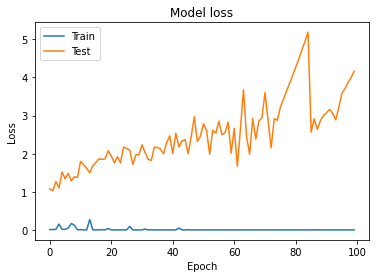

In [13]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
custom_model.eval()
true_label=[]
pred_label=[]
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        if(len(labels)!=hyper_param_batch):
            break
        outputs = custom_model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)

        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))



Test Accuracy of the model on the 2896 test images: 66.29834254143647 %


In [18]:
import csv


with open("valid_loss_history_0721_1.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)

In [19]:
import csv


with open("train_loss_history_0721_1.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)


In [20]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2154
           1       0.36      0.41      0.38       742

    accuracy                           0.66      2896
   macro avg       0.57      0.58      0.58      2896
weighted avg       0.68      0.66      0.67      2896



In [ ]:

model=CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/model_check/model_3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        if(len(labels)!=8):
            break
        outputs = model(npys)
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))



NameError: name 'CNN' is not defined